__Student info:__

- Student name: Thomas Brown
- Student pace: Full Time
- Scheduled project review date/time: 09/21/20
- Instructor name: Abhineet Kulkarni
- Blog post URL: [Link Here](https://thomaskbrown18.github.io/sentiment_analysis_on_financial_news_headlines)

__Project Description:__<br><br>
The purpose of this project is to build an artificial neural network model that can determine the sentiment of financial news headlines.  The users of this model would be investment firms in order to keep track of the market sentiment of a set of various products, companies, or industries.  <br><br>
With proper web scraping and feeding of new headlines, a firm would be able to keep track of various topics to make better informed investing decisions.  You could think of it as another type of stock ticker, but for tracking sentiment instead of stock price.  For example, one could feasibly keep track of terms that are rising rapidly in terms of positive sentiment in order to invest in them.<br><br>
The data is collected from Kaggle through this [link](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news).  It's a collection of 4,846 unique news headlines from various financial news sources. 

## Importing Libraries:

In [1]:
import pandas as pd
import numpy as np

# Keras:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling1D
from keras.callbacks import EarlyStopping

# NLTK - Stopwords:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

# Plots and Graphs:
from wordcloud import WordCloud
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import plotly.express as px
import scikitplot as skplt 
%matplotlib inline

# Scikit-Learn:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Other:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
# So we can see the entire column:
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.
/Users/Thomas/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Importing Data:

In [2]:
df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df.head())
print("Shape:", df.shape, "\n\n")
print(df.info())

Sentiment  \
0  neutral    
1  neutral    
2  positive   
3  positive   
4  neutral    

                                                                                                                                                                                                                                                                     Headline  
0  The equipment Ixonos acquires with this deal includes mechanical engineering hardware ; an RF and antenna measurement laboratory ; facilities for the measurement of audio , cameras and displays ; as well as devices and robot units for the testing of mobile devices .  
1  `` Tweeple should check who 's following them , and be cautious when clicking on URLs and tinyurls . ''                                                                                                                                                                     
2  Satama earned Data Management Solutions competency with Business Intelligence specialization recentlyvia the acquisition of Fimentor Oy .                                                                                                                                   
3  ( ADP News ) - Nov 3 , 2008 - Finnish cargo handling systems and services company Cargotec Oyj ( OMX : CGCBV ) said today that it acquired 80 % stakes in Italian service companies CVS Technoports Srl and CVS Service Srl from Italian handli                             
4  Particular attention is being paid to energy efficiency in the construction of the building , as it is designed to meet the requirements of energy class B , and LEED certification will be applied for .

Shape: (4846, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
Sentiment    4846 non-null object
Headline     4846 non-null object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [3]:
# Let's take a look at the number of instances of each sentiment:
df.Sentiment.value_counts()
# Not too many negatives.  This may prove to be an issue later on, but for now, let's keep moving.

neutral     2879
positive    1363
negative    604 
Name: Sentiment, dtype: int64

# Cleaning Data:

First, the labels need to be changed to numerical values in order to go through the neural network later on. Due to a low number of negative articles compared to the rest, I'll be treating this as a binary problem: 'Positive' vs 'Not Positive'.  Another advantage to this approach is that instead of a ternary classification problem, the neural network outputs one value, from 0 to 1, with 1 being positive and 0 being negative.  This allows for a gradient of sentiment.<br><br>
For example, a headline that's moderately positive should get a sentiment value of .75.  This can allow for a bit more nuance in terms of evaluation later on, especially when we examine individual headlines.

- 0 is Negative or Neutral
- 1 is Positive

In [4]:
# BINARY
df['Sentiment'] = df['Sentiment'].map(lambda x: 1 if x == 'positive' else 0)
df.head()

Sentiment  \
0  0           
1  0           
2  1           
3  1           
4  0           

                                                                                                                                                                                                                                                                     Headline  
0  The equipment Ixonos acquires with this deal includes mechanical engineering hardware ; an RF and antenna measurement laboratory ; facilities for the measurement of audio , cameras and displays ; as well as devices and robot units for the testing of mobile devices .  
1  `` Tweeple should check who 's following them , and be cautious when clicking on URLs and tinyurls . ''                                                                                                                                                                     
2  Satama earned Data Management Solutions competency with Business Intelligence specialization recentlyvia the acquisition of Fimentor Oy .                                                                                                                                   
3  ( ADP News ) - Nov 3 , 2008 - Finnish cargo handling systems and services company Cargotec Oyj ( OMX : CGCBV ) said today that it acquired 80 % stakes in Italian service companies CVS Technoports Srl and CVS Service Srl from Italian handli                             
4  Particular attention is being paid to energy efficiency in the construction of the building , as it is designed to meet the requirements of energy class B , and LEED certification will be applied for .

## Stopwords:

Next, we can remove all the 'stopwords' that can clog up the system later on.  The punctuation will get filtered out later.

In [5]:
stop = set(stopwords.words('english'))
stop.add("'s")
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Headline'] = df['Headline'].map(remove_stopwords)

In [6]:
df.head()

Sentiment  \
0  0           
1  0           
2  1           
3  1           
4  0           

                                                                                                                                                                                                                  Headline  
0  equipment ixonos acquires deal includes mechanical engineering hardware ; rf antenna measurement laboratory ; facilities measurement audio , cameras displays ; well devices robot units testing mobile devices .        
1  `` tweeple check following , cautious clicking urls tinyurls . ''                                                                                                                                                        
2  satama earned data management solutions competency business intelligence specialization recentlyvia acquisition fimentor oy .                                                                                            
3  ( adp news ) - nov 3 , 2008 - finnish cargo handling systems services company cargotec oyj ( omx : cgcbv ) said today acquired 80 % stakes italian service companies cvs technoports srl cvs service srl italian handli  
4  particular attention paid energy efficiency construction building , designed meet requirements energy class b , leed certification applied .

## Lemmatization:

Lemmatization will change a word like 'Running' into 'run'.  This simplification of the words makes it possible for the neural network later on to treat 'Running', 'run', 'ran', and 'runs' exactly the same, for example.  You lose some nuance in the sentence as you'll soon see, but it makes it much easier for the model to learn in the end.  Below are some headlines after lemmatization:

In [7]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [8]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return " ".join(text)

df['Headline'] = df['Headline'].map(lemmatize)

In [9]:
# Still looking good
df.head()

Sentiment  \
0  0           
1  0           
2  1           
3  1           
4  0           

                                                                                                                                                                                                       Headline  
0  equipment ixonos acquires deal include mechanical engineering hardware ; rf antenna measurement laboratory ; facility measurement audio , camera display ; well device robot unit test mobile device .        
1  `` tweeple check follow , cautious click url tinyurls . ''                                                                                                                                                    
2  satama earn data management solution competency business intelligence specialization recentlyvia acquisition fimentor oy .                                                                                    
3  ( adp news ) - nov 3 , 2008 - finnish cargo handle system service company cargotec oyj ( omx : cgcbv ) say today acquire 80 % stake italian service company cv technoports srl cv service srl italian handli  
4  particular attention paid energy efficiency construction building , design meet requirement energy class b , leed certification apply .

# EDA:

In [10]:
# Let's start by exploring sentence length vs sentiment:
df_eda = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                     encoding='latin-1')
df_eda = df_eda.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
df_eda['Sentiment'] = df_eda['Sentiment'].map(lambda x: 'positive' if x == 'positive' else 'neutral/neg')
# Same dataset as before:

In [11]:
sent_len = []
for row in df_eda.Headline:
    x = (len(row.split()))
    sent_len.append(x)
    
df_eda['Sentence_Length'] = sent_len

In [12]:
df_eda.head()

Sentiment  \
0  positive      
1  positive      
2  positive      
3  positive      
4  neutral/neg   

                                                                                                                                                                                                 Headline  \
0  For Telenor , the three and a half year contract is worth an estimated 12.6 m. YIT has chosen Telenor and Elisa as its principal suppliers of ICT solutions in Norway , Sweden , Denmark and Finland .   
1  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .                       
2  Sports equipment sales also progressed well owing to the prolonged winter season .                                                                                                                       
3  Exports accounted for 65.4 % of net sales , representing an all time record for the company .                                                                                                            
4  After the split , the number of K shares will be 9 540 000 and the number of A shares 26 885 540 .                                                                                                       

   Sentence_Length  
0  38               
1  25               
2  13               
3  18               
4  24

In [14]:
df_pos = df_eda[df_eda['Sentiment'] == 'positive']
df_neg = df_eda[df_eda['Sentiment'] == 'neutral/neg']

Positive Headlines - Green, and Negative/Neutral Headlines - Blue


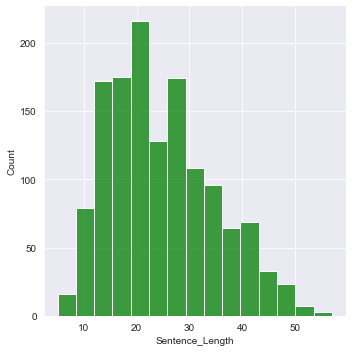

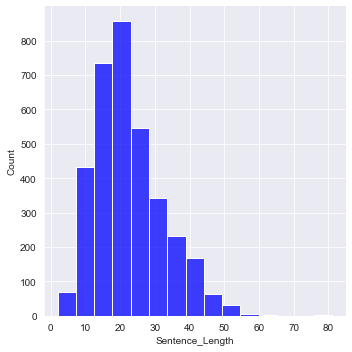

In [15]:
print ('Positive Headlines - Green, and Negative/Neutral Headlines - Blue') 
sns.displot(df_pos, x = 'Sentence_Length', color = 'g', bins = 15)
sns.displot(df_neg, x = 'Sentence_Length', color = 'b', bins = 15);

Positive headlines (Green) appear to more commonly be longer, but it's a bit too close to tell for certain.

Let's explore some word clouds to see the most commonly occurring words for each label.

In [16]:
# Separating out the categories
pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]

In [17]:
 def wordcloud(dataset):
    plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
    wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(dataset))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show();

def show_wordclouds():
    print ('Positive Sentiment Wordcloud:')
    wordcloud(pos)
    ###
    print ('Negative Sentiment Wordcloud:')
    wordcloud(neg)
    ###
    

Positive Sentiment Wordcloud:


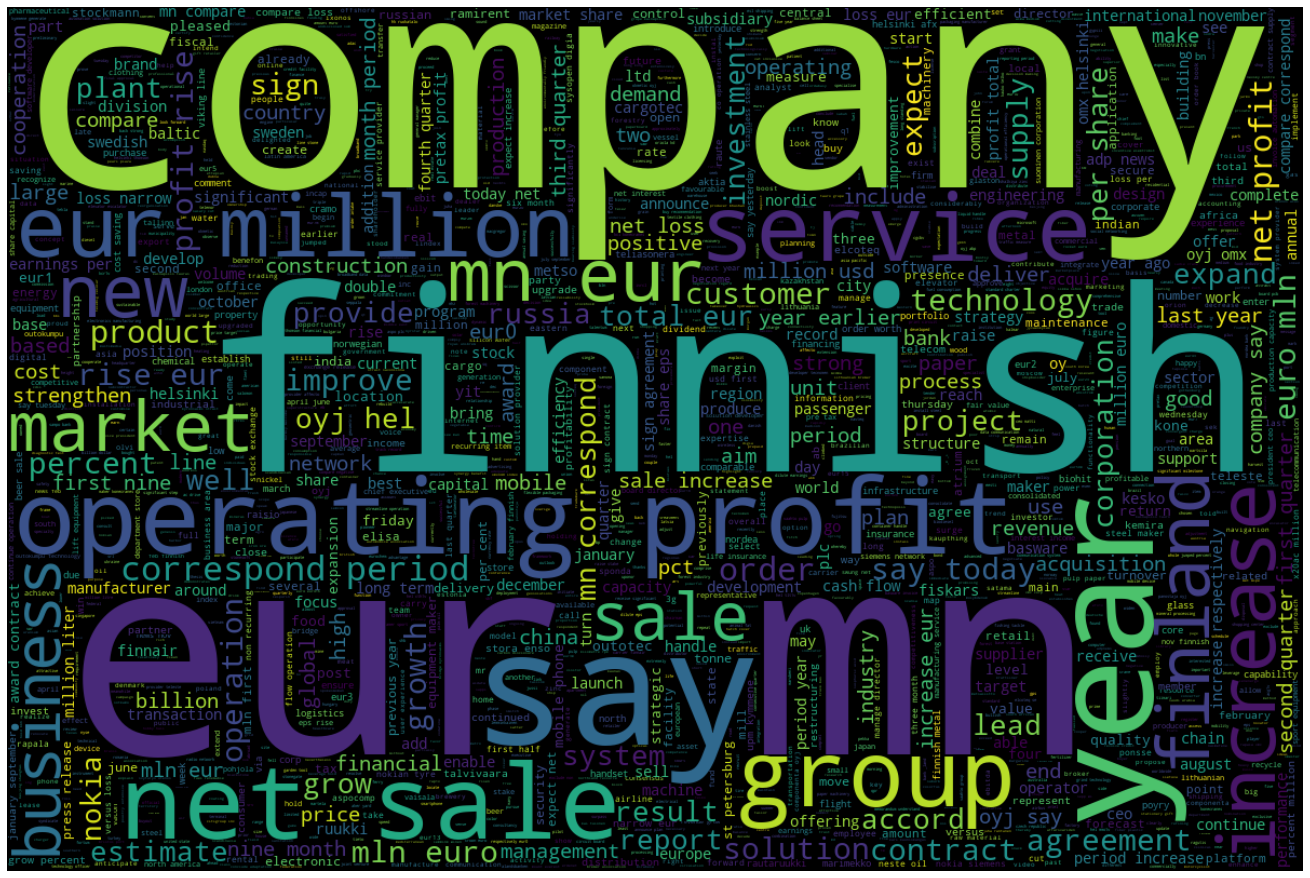

Negative Sentiment Wordcloud:


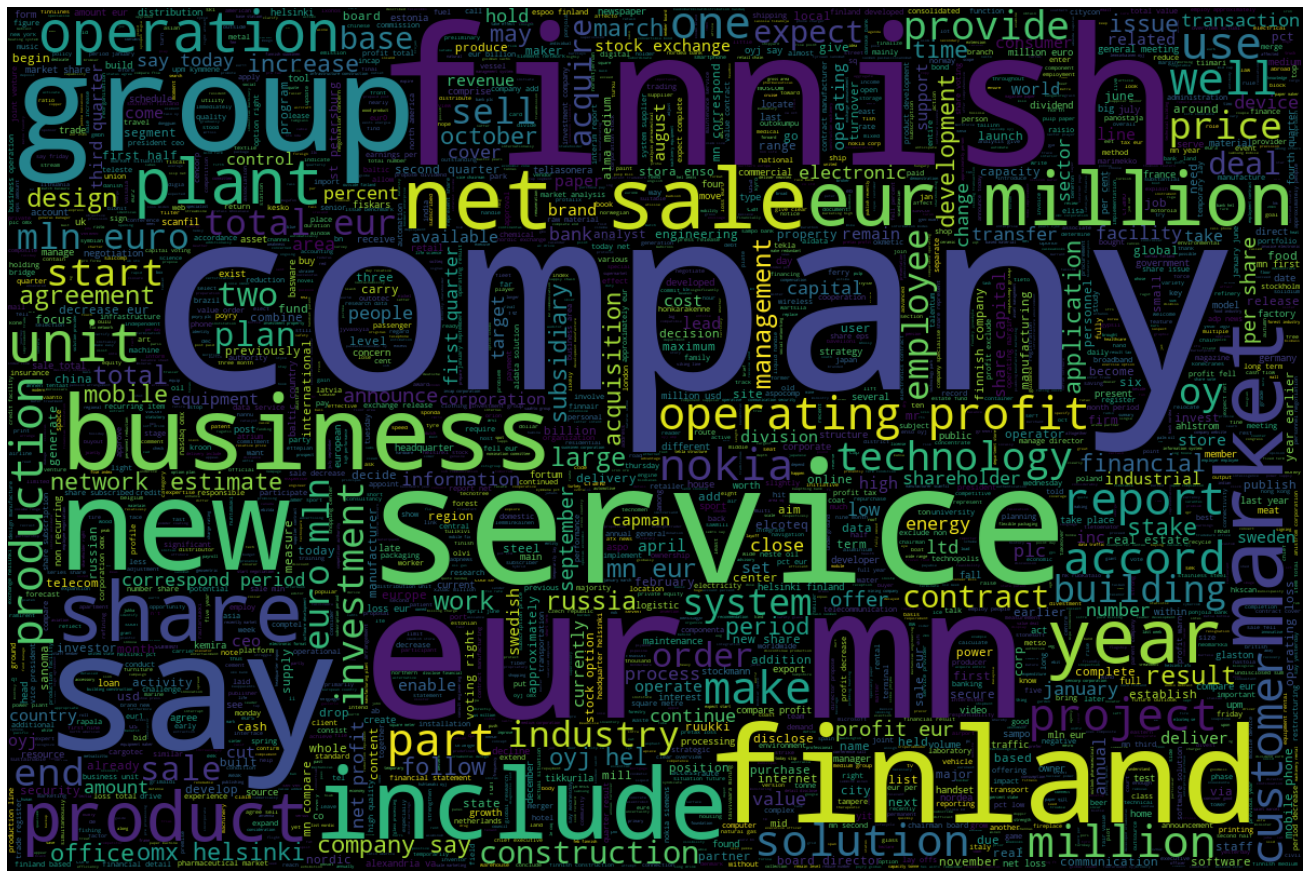

In [18]:
# Showing Word Clounds
show_wordclouds()

Not too much useful information here.  There are some more words we can clean, but I would like to stay on the conservative side for now.

# Additional Cleaning:

As we saw above, there are a few words that are quite common that occur in all 3 labels.  We'll add this to these to the stop word list and run the headlines through the filter again:
- 'finnish'
- 'say'
- 'company'

In [19]:
# Taking out a few more stop words:
stop.add("finnish")
stop.add("say")
stop.add("company")

df['Headline'] = df['Headline'].map(remove_stopwords)

In [20]:
# Starting to feel a little like caveman speak, but hopefully this will be easier for the model to read!
df.head()

Sentiment  \
0  0           
1  0           
2  1           
3  1           
4  0           

                                                                                                                                                                                                 Headline  
0  equipment ixonos acquires deal include mechanical engineering hardware ; rf antenna measurement laboratory ; facility measurement audio , camera display ; well device robot unit test mobile device .  
1  `` tweeple check follow , cautious click url tinyurls . ''                                                                                                                                              
2  satama earn data management solution competency business intelligence specialization recentlyvia acquisition fimentor oy .                                                                              
3  ( adp news ) - nov 3 , 2008 - cargo handle system service cargotec oyj ( omx : cgcbv ) today acquire 80 % stake italian service cv technoports srl cv service srl italian handli                        
4  particular attention paid energy efficiency construction building , design meet requirement energy class b , leed certification apply .

In [21]:
pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]


Positive Sentiment Wordcloud:


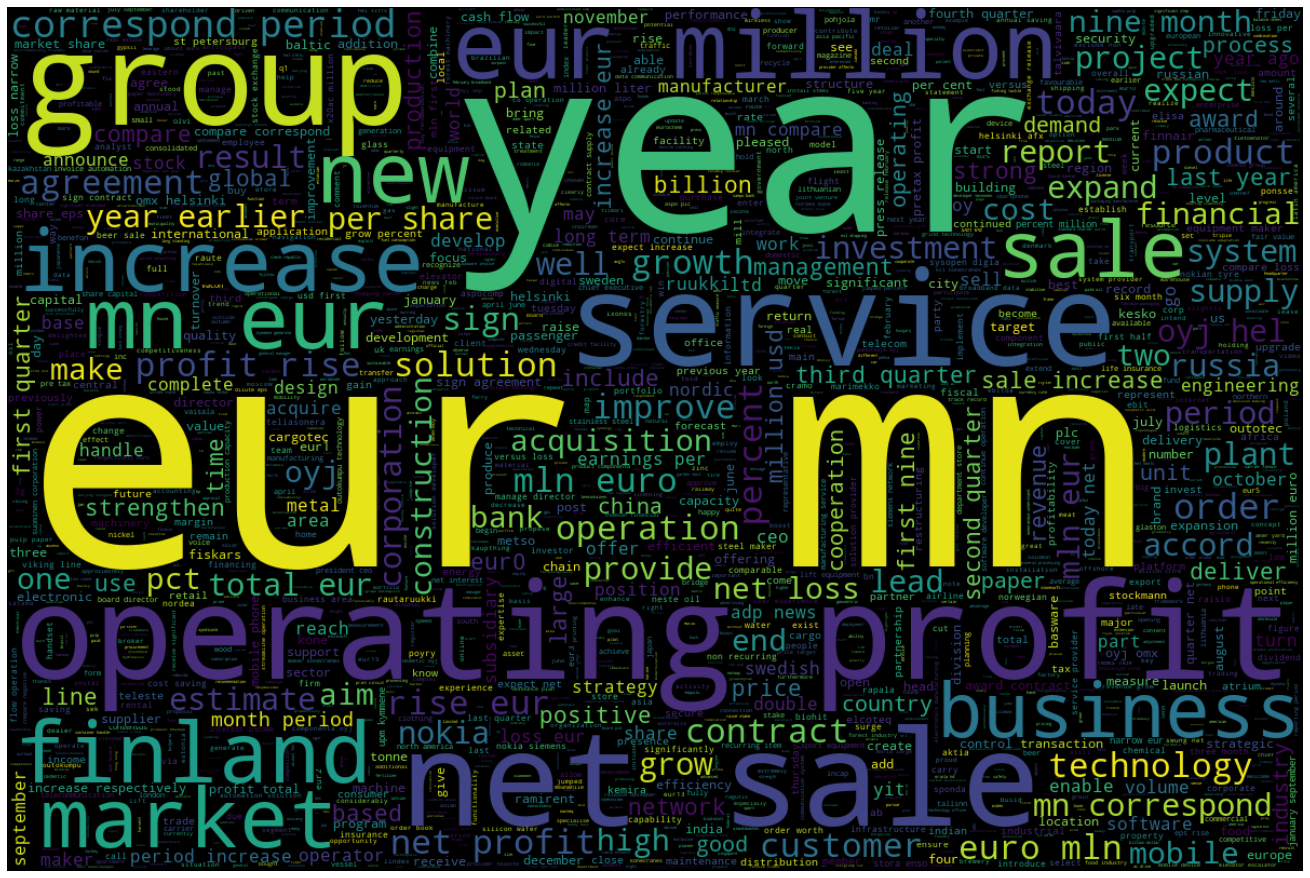

Negative Sentiment Wordcloud:


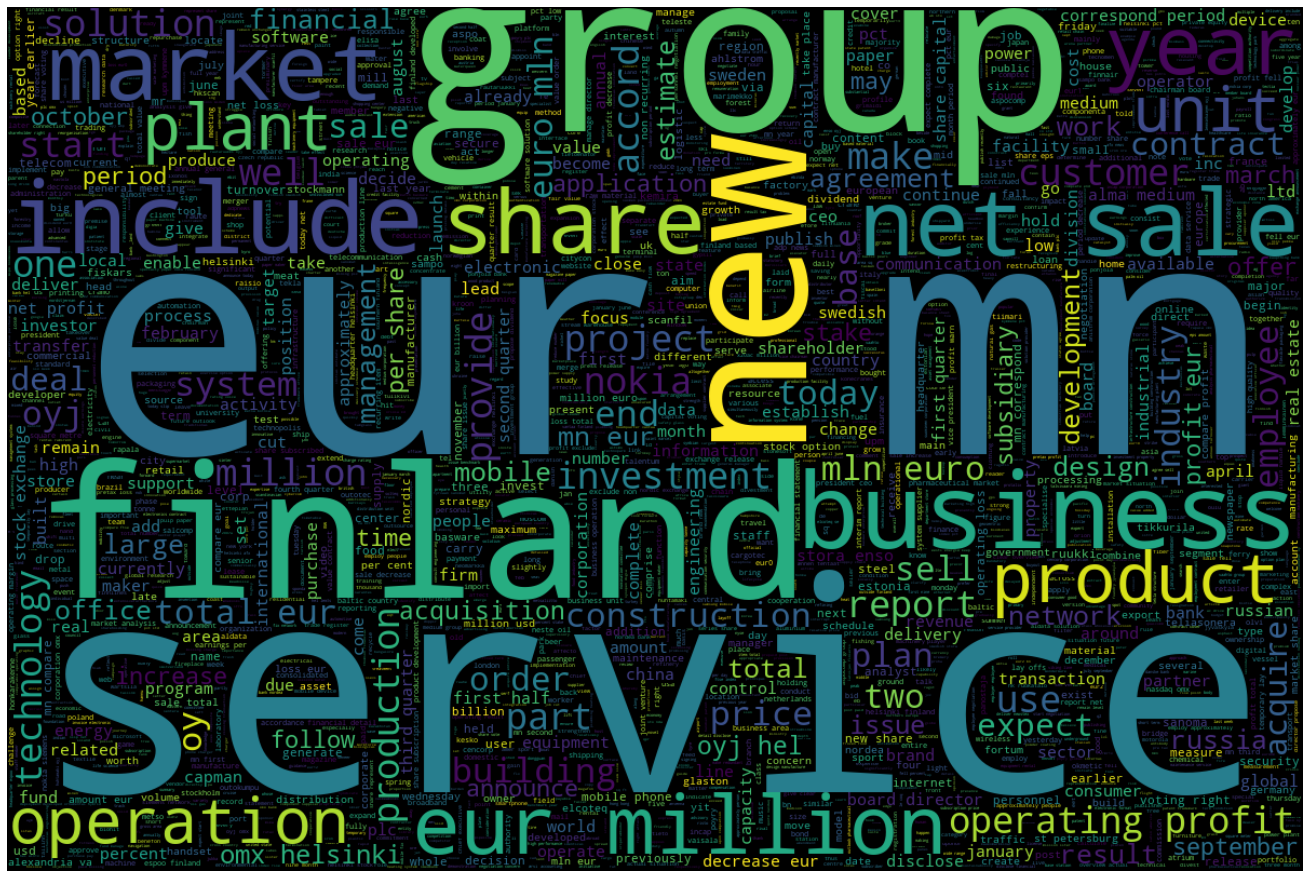

In [22]:
# Showing Word Clounds with additional words removed
show_wordclouds()

# Counter:

In [23]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [24]:
text = df.Headline
counter = counter_word(text)

In [25]:
len(counter)

10094

In [26]:
# showing the first 25 rows of the counter
n = 25
out = dict(list(counter.items())[0: n])  
out

{'equipment': 83,
 'ixonos': 12,
 'acquires': 4,
 'deal': 79,
 'include': 196,
 'mechanical': 8,
 'engineering': 55,
 'hardware': 7,
 ';': 30,
 'rf': 1,
 'antenna': 5,
 'measurement': 12,
 'laboratory': 10,
 'facility': 70,
 'audio': 5,
 ',': 4662,
 'camera': 5,
 'display': 4,
 'well': 116,
 'device': 56,
 'robot': 1,
 'unit': 135,
 'test': 24,
 'mobile': 134,
 '.': 4780}

In [27]:
num_words = len(counter)

# Train/Test Split:

In [28]:
# Generating the lists of headlines and labels
headlines = []
labels = []

for row in range(len(df)):
    headlines.append(df['Headline'][row])
    labels.append(df['Sentiment'][row])

In [29]:
# Setting the training ratio
training_size = int(df.shape[0] * .8) # Out of 4846

In [30]:
# Train Test Split:
# Already shuffled, so we're good to go
training_headlines = headlines[0:training_size]
testing_headlines = headlines[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [31]:
# Looks good
display(training_headlines[:3])
display(training_labels[:3])

['equipment ixonos acquires deal include mechanical engineering hardware ; rf antenna measurement laboratory ; facility measurement audio , camera display ; well device robot unit test mobile device .',
 "`` tweeple check follow , cautious click url tinyurls . ''",
 'satama earn data management solution competency business intelligence specialization recentlyvia acquisition fimentor oy .']

[0, 0, 1]

# Tokenization:

Tokenization is an important step of the process.  It creates a number coded to each word in the vocabulary.  This way, the neural network is able to build patterns and learn meaning.  Examples of the process can be seen below.  <br><br>
In order to keep all headlines the same length, I'm creating a max length of 50 words (only a handful of headlines are longer), and a sentence that is shorter than that will be filled for the remainder with 0s.  This process is called padding.

In [32]:
vocab_size = len(counter) # approx 1/5 of the words 
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [33]:

# Initializing the fitting the tokenizer:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_headlines)
# Initializing the Word Index:
word_index = tokenizer.word_index
# Padding and Sequencing the Training Set:
training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen = max_length,
                               padding = padding_type, 
                               truncating = trunc_type)
# Padding and Sequencing the Testing Set:
testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, 
                               padding = padding_type, 
                               truncating = trunc_type)


In [34]:
# Switch to Numpy Array
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [35]:
# Example of what's happening under the hood:
print ('Padded and Tokenized Headline:\n', training_padded[3])
print ('\nThe actual headline:\n', df.Headline[3])
print ('\nLabel:\n', training_labels[3])

Padded and Tokenized Headline:
 [ 403  141 1114   15   17  673  341   61   11  506   36  107 2071   54
  146  507  191 1533   11 1534 3699 2072 1534   11 2072 1533 3700    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]

The actual headline:
 ( adp news ) - nov 3 , 2008 - cargo handle system service cargotec oyj ( omx : cgcbv ) today acquire 80 % stake italian service cv technoports srl cv service srl italian handli

Label:
 1


## Taking a Look at Inputs:

In [36]:
# So far looks good:
n = 0

display(training_headlines[n])
print('-----------------')
display(training_padded[n])
print('-----------------')
display(training_labels[n])
print('-----------------')

display(testing_headlines[n])
print('-----------------')
display(testing_padded[n])
print('-----------------')
display(testing_labels[n])
print('-----------------')


'equipment ixonos acquires deal include mechanical engineering hardware ; rf antenna measurement laboratory ; facility measurement audio , camera display ; well device robot unit test mobile device .'

-----------------


array([ 127, 1013, 2067,  124,   43, 1113,  196, 1529, 3692, 1530, 1014,
        946,  145, 1014, 1531, 2068, 2069,   73,  211, 3693,   67,  458,
         62,  211,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

-----------------


0

-----------------


'www.countryelements.co.uk design patricia burt , one selection distinctive hooked rug create recycle material dyed natural dye .'

-----------------


array([ 468,    1,  491,  444,  131,    1,    1,   75, 2485,    1,    1,
          1,  718,  934,  212,    1,  619,    1,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

-----------------


0

-----------------


In [37]:
# Making sure all our process hasn't shuffled anything and we can still decode. . . 
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '-') for i in text])

print(decode_sentence(training_padded[1]))
print(training_headlines[1])
print(labels[1])

tweeple check follow cautious click url tinyurls '' - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
`` tweeple check follow , cautious click url tinyurls . ''
0


# Modeling:

## Baseline with Vader:

Vader is a commonly used sentiment analysis toolbox.  Let's see if we can use it as a baseline against the artificial neural network I'll build later on in the notebook.

In [38]:
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [39]:
# Vader Accuracy:
# Making a new dataframe to mess around in:
df2 = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df2 = df2.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
df2['Sentiment'] = df2['Sentiment'].map(lambda x: 1 if x == 'positive' else 0)
df2['vader_sent'] = 0 # Placeholder as 0
df2 = df2[['Sentiment', 'vader_sent', 'Headline']]
df2.head()

Sentiment  vader_sent  \
0  0          0            
1  1          0            
2  0          0            
3  1          0            
4  1          0            

                                                                                                                                                                                                         Headline  
0  Net sales in 2010 were about EUR 2.0 billion , of which international operations accounted for roughly a quarter .                                                                                              
1  credit 20 November 2009 - Finnish glass technology company Glaston Oyj Abp ( HEL : GLA1V ) said today it concluded a EUR74m revolving credit facility agreement with its core banks .                           
2  The five-storey , eco-efficient building will have a gross floor area of about 15,000 sq m. It will also include apartments .                                                                                   
3  The costs of the new ropax vessels are 30 % lower than those of the present ones .                                                                                                                              
4  More than 200 volunteers from Fiskars , the garden tool company , Home Depot ( NYSE : HD ) , the city of Baltimore and the neighborhood are working right now to create a garden sanctuary - in a single day .

In [40]:
# Sanity check:
x = sid.polarity_scores('This is a happy sentence!')
print (x)
print (x['compound'])

{'neg': 0.0, 'neu': 0.274, 'pos': 0.726, 'compound': 0.6476}
0.6476


In [41]:
vader_sent_list = []
for row in df2.Headline:
    x = sid.polarity_scores(row)['compound']
    vader_sent_list.append(x)
    
df2.vader_sent = vader_sent_list
df2.head()
# Looks good, but we'll need to change vader_sent to the same format as Sentiment
# The 'Compound' score we're using uses a scale of -1 to 1, while Sentiment is 0 to 1

Sentiment  vader_sent  \
0  0          0.0000       
1  1          0.8126       
2  0         -0.4767       
3  1         -0.2960       
4  1          0.2732       

                                                                                                                                                                                                         Headline  
0  Net sales in 2010 were about EUR 2.0 billion , of which international operations accounted for roughly a quarter .                                                                                              
1  credit 20 November 2009 - Finnish glass technology company Glaston Oyj Abp ( HEL : GLA1V ) said today it concluded a EUR74m revolving credit facility agreement with its core banks .                           
2  The five-storey , eco-efficient building will have a gross floor area of about 15,000 sq m. It will also include apartments .                                                                                   
3  The costs of the new ropax vessels are 30 % lower than those of the present ones .                                                                                                                              
4  More than 200 volunteers from Fiskars , the garden tool company , Home Depot ( NYSE : HD ) , the city of Baltimore and the neighborhood are working right now to create a garden sanctuary - in a single day .

In [42]:
# Greater than 50% (i.e. 0 or neutral) on the vader compound score gets it. . . 
# . . . classified as a 1 i.e. 'positive' on our scale
df2['vader_sent'] = df2['vader_sent'].map(lambda x: 1 if x > 0 else 0)
df2.head()

Sentiment  vader_sent  \
0  0          0            
1  1          1            
2  0          0            
3  1          0            
4  1          1            

                                                                                                                                                                                                         Headline  
0  Net sales in 2010 were about EUR 2.0 billion , of which international operations accounted for roughly a quarter .                                                                                              
1  credit 20 November 2009 - Finnish glass technology company Glaston Oyj Abp ( HEL : GLA1V ) said today it concluded a EUR74m revolving credit facility agreement with its core banks .                           
2  The five-storey , eco-efficient building will have a gross floor area of about 15,000 sq m. It will also include apartments .                                                                                   
3  The costs of the new ropax vessels are 30 % lower than those of the present ones .                                                                                                                              
4  More than 200 volunteers from Fiskars , the garden tool company , Home Depot ( NYSE : HD ) , the city of Baltimore and the neighborhood are working right now to create a garden sanctuary - in a single day .

In [43]:
# Score counter for accuracy:
# 1 for correct sentiment, 0 for no match
df2['vader_sent_match'] = 1 - abs(df2['vader_sent'] - df2['Sentiment'])
df2 = df2[['Sentiment', 'vader_sent', 'vader_sent_match', 'Headline']]
df2.head(10)

Sentiment  vader_sent  vader_sent_match  \
0  0          0           1                  
1  1          1           1                  
2  0          0           1                  
3  1          0           0                  
4  1          1           1                  
5  1          1           1                  
6  0          0           1                  
7  1          1           1                  
8  0          0           1                  
9  0          0           1                  

                                                                                                                                                                                                         Headline  
0  Net sales in 2010 were about EUR 2.0 billion , of which international operations accounted for roughly a quarter .                                                                                              
1  credit 20 November 2009 - Finnish glass technology company Glaston Oyj Abp ( HEL : GLA1V ) said today it concluded a EUR74m revolving credit facility agreement with its core banks .                           
2  The five-storey , eco-efficient building will have a gross floor area of about 15,000 sq m. It will also include apartments .                                                                                   
3  The costs of the new ropax vessels are 30 % lower than those of the present ones .                                                                                                                              
4  More than 200 volunteers from Fiskars , the garden tool company , Home Depot ( NYSE : HD ) , the city of Baltimore and the neighborhood are working right now to create a garden sanctuary - in a single day .  
5  Profit before taxes was EUR 5.4 mn , up from EUR 3.6 mn a year earlier .                                                                                                                                        
6  Rohwedder Group is an automotive supplies , telecommunications and electronics industry provider for customers in Europe , North America and Asia .                                                             
7  Net sales of Finnish food industry company L+Ænnen Tehtaat 's continuing operations increased by 13 % in 2008 to EUR 349.1 mn from EUR 309.6 mn in 2007 .                                                       
8  Finnish stainless steel manufacturer Outokumpu in Degefors is planning to recruit new engineers in order to meet a retirement wave over the next few years .                                                    
9  The total restructuring costs are expected to be about EUR 30mn , of which EUR 13.5 mn was booked in December 2008 .

In [44]:
x = sum(df2['vader_sent_match'])
y = len(df2)
print ('Correct Vader Classifications:', x, 'out of', y)
print ('Percentage Correct:', '{:.2%}'.format(x/y))

Correct Vader Classifications: 3004 out of 4846
Percentage Correct: 61.99%


With the threshold of greater than 50% classified as 'Positive', we got 62% accuracy with Vader.  Let's see if we can do a better job with an artificial neural network.

# Neural Network:

In [45]:
# First let's define the functions for model evaluation
def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def model_metrics(model):
    train_acc = model.evaluate(training_padded, training_labels, verbose=0)
    test_acc = model.evaluate(testing_padded, testing_labels, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))
    
# Made up some easy headlines to see if the ANN works
def easy_headlines():
    sentence = ["stock rise rapid for tesla", 
                "apple factory shut down, lay off hundred employee",
                "average day of return for microsoft"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))
    
# Random headlines from NYT Business  (post stopword removal and lemmatization) 
# This may be a bit trickier for the network
def harder_headlines():
    sentence = ["snowflake more  double  debut  wall street embrace tech ipos", 
                "europe economic revival imperil raising the specter grind downturn",
                "fed debate next step after shifting approach to rate setting"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))

def test_headlines():
    print('Easier Headlines:')
    easy_headlines()
    print ('\n')
    print ('Realistic Headlines:')
    harder_headlines()

Now it's time to build a baseline neural network:

## Model 1 (1 Hidden Layer):

In [46]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(1, activation='sigmoid'))

# Slower learning rate worked better as it kept the learning more stable
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer= opt, 
              metrics=['accuracy']) # Orig code

In [47]:
num_epochs = 50
# After 5 epochs of validation loss not improving, the model will stop.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 10,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks=[es])

Train on 3876 samples, validate on 970 samples
Epoch 1/50
3876/3876 [==============================] - 3s 686us/step - loss: 0.6388 - acc: 0.7170 - val_loss: 0.5922 - val_acc: 0.7258
Epoch 2/50
3876/3876 [==============================] - 2s 568us/step - loss: 0.5903 - acc: 0.7170 - val_loss: 0.5799 - val_acc: 0.7258
Epoch 3/50
3876/3876 [==============================] - 2s 581us/step - loss: 0.5862 - acc: 0.7170 - val_loss: 0.5775 - val_acc: 0.7258
Epoch 4/50
3876/3876 [==============================] - 2s 582us/step - loss: 0.5826 - acc: 0.7170 - val_loss: 0.5743 - val_acc: 0.7258
Epoch 5/50
3876/3876 [==============================] - 2s 589us/step - loss: 0.5775 - acc: 0.7170 - val_loss: 0.5712 - val_acc: 0.7258
Epoch 6/50
3876/3876 [==============================] - 2s 565us/step - loss: 0.5719 - acc: 0.7170 - val_loss: 0.5672 - val_acc: 0.7258
Epoch 7/50
3876/3876 [==============================] - 2s 550us/step - loss: 0.5650 - acc: 0.7170 - val_loss: 0.5612 - val_acc: 0.7258
E

### Model Evaluation:

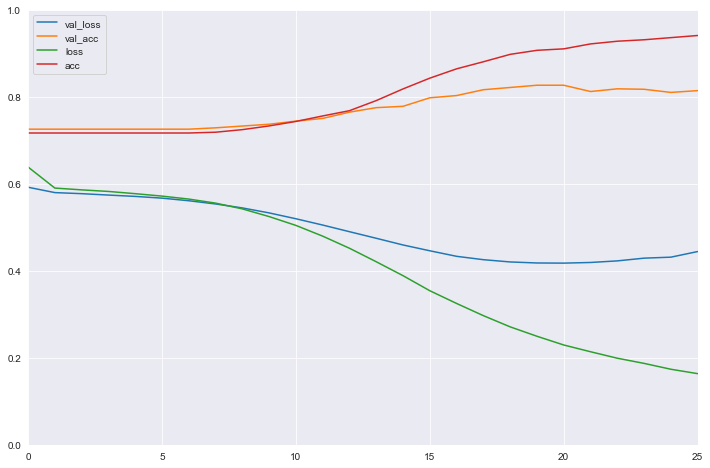

In [48]:
model_eval(history)

In [49]:
model_metrics(model)

Train Loss: 15.327%
Train Accuracy: 94.453%
Test Loss: 44.439%
Test Accuracy: 81.443%


In [50]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[0.65898937]
 [0.00433384]
 [0.41493252]]


Realistic Headlines:
snowflake more  double  debut  wall street embrace tech ipos
europe economic revival imperil raising the specter grind downturn
fed debate next step after shifting approach to rate setting
[[0.15976714]
 [0.08531874]
 [0.17500685]]


While there's room for improvement with ~81% accuracy, this ended up being my best performing model.  I'm including the following models as well to show some different approaches I tried.

## Model 2 (2 Hidden Layers):

In [51]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(50, activation='relu')) # Optional second hidden layer
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer= opt, 
              metrics=['accuracy']) 

In [52]:
num_epochs = 50
# Same early stopping as before  
# 5 seems to be a good number given the slow and steady learning rate.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 10,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks=[es])

Train on 3876 samples, validate on 970 samples
Epoch 1/50
3876/3876 [==============================] - 2s 567us/step - loss: 0.6645 - acc: 0.7030 - val_loss: 0.6223 - val_acc: 0.7258
Epoch 2/50
3876/3876 [==============================] - 2s 502us/step - loss: 0.6024 - acc: 0.7170 - val_loss: 0.5826 - val_acc: 0.7258
Epoch 3/50
3876/3876 [==============================] - 2s 525us/step - loss: 0.5919 - acc: 0.7170 - val_loss: 0.5795 - val_acc: 0.7258
Epoch 4/50
3876/3876 [==============================] - 2s 518us/step - loss: 0.5914 - acc: 0.7170 - val_loss: 0.5779 - val_acc: 0.7258
Epoch 5/50
3876/3876 [==============================] - 2s 534us/step - loss: 0.5866 - acc: 0.7170 - val_loss: 0.5754 - val_acc: 0.7258
Epoch 6/50
3876/3876 [==============================] - 2s 531us/step - loss: 0.5821 - acc: 0.7170 - val_loss: 0.5731 - val_acc: 0.7258
Epoch 7/50
3876/3876 [==============================] - 2s 532us/step - loss: 0.5778 - acc: 0.7170 - val_loss: 0.5694 - val_acc: 0.7258
E

### Model Evaluation:

In [53]:
model_metrics(model)

Train Loss: 14.057%
Train Accuracy: 95.330%
Test Loss: 47.171%
Test Accuracy: 80.825%


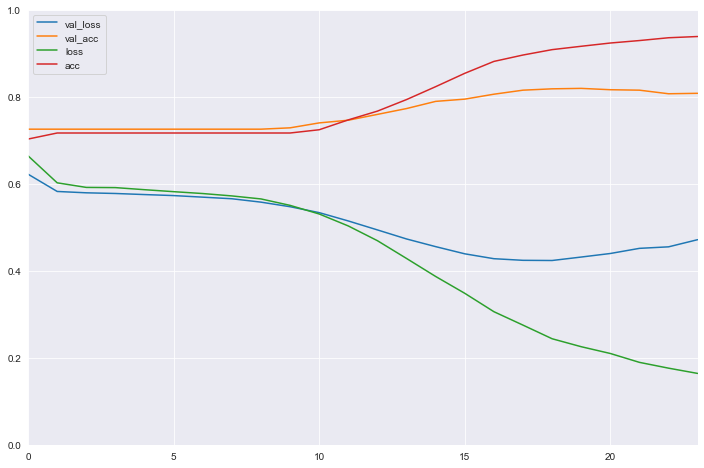

In [54]:
model_eval(history)

In [55]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[0.77695554]
 [0.00285289]
 [0.44502088]]


Realistic Headlines:
snowflake more  double  debut  wall street embrace tech ipos
europe economic revival imperil raising the specter grind downturn
fed debate next step after shifting approach to rate setting
[[0.12380619]
 [0.04459891]
 [0.10985331]]


## Model 3 (LSTM):

LSTM (Long Short Term Memory) models are quite popular as well for NLP.  Let's give it a try.

In [56]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1))
model.add(Dense(35, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [57]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 24,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks = [es])

Train on 3876 samples, validate on 970 samples
Epoch 1/50
3876/3876 [==============================] - 14s 4ms/step - loss: 0.6025 - acc: 0.7170 - val_loss: 0.5902 - val_acc: 0.7258
Epoch 2/50
3876/3876 [==============================] - 13s 3ms/step - loss: 0.5592 - acc: 0.7299 - val_loss: 0.5410 - val_acc: 0.7258
Epoch 3/50
3876/3876 [==============================] - 14s 4ms/step - loss: 0.5189 - acc: 0.7784 - val_loss: 0.5564 - val_acc: 0.7557
Epoch 4/50
3876/3876 [==============================] - 14s 4ms/step - loss: 0.5026 - acc: 0.7724 - val_loss: 0.5747 - val_acc: 0.6371
Epoch 5/50
3876/3876 [==============================] - 15s 4ms/step - loss: 0.4605 - acc: 0.7332 - val_loss: 0.5655 - val_acc: 0.7258
Epoch 6/50
3876/3876 [==============================] - 14s 4ms/step - loss: 0.4456 - acc: 0.7283 - val_loss: 0.6120 - val_acc: 0.6351
Epoch 7/50
3876/3876 [==============================] - 14s 4ms/step - loss: 0.4438 - acc: 0.7384 - val_loss: 0.6090 - val_acc: 0.6330
Epoch 00

### Model Evaluation:

In [58]:
model_metrics(model)

Train Loss: 43.471%
Train Accuracy: 74.897%
Test Loss: 60.898%
Test Accuracy: 63.299%


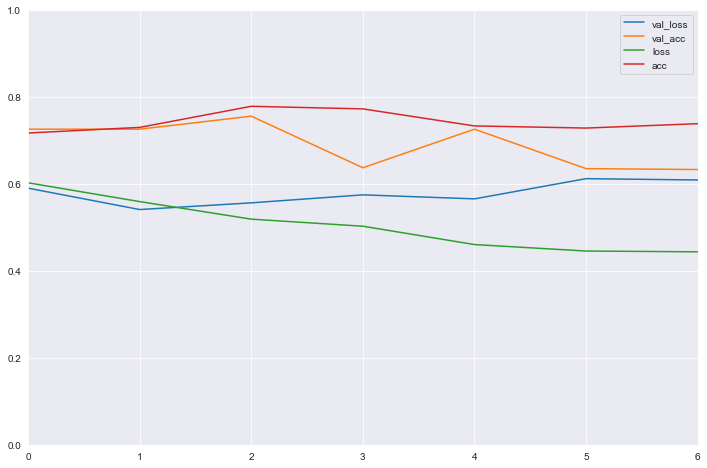

In [59]:
model_eval(history)

In [60]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[0.5261286 ]
 [0.04431633]
 [0.52612877]]


Realistic Headlines:
snowflake more  double  debut  wall street embrace tech ipos
europe economic revival imperil raising the specter grind downturn
fed debate next step after shifting approach to rate setting
[[0.5261286 ]
 [0.04432962]
 [0.04432609]]


## Transfer Learning with GloVe:

[Source](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

Now, I'll be trying out a pre-trained model called GloVe to prime the embedding layer of this project.  Let's see if we can get better results with this network.

In [61]:
from numpy import array
from numpy import asarray
from numpy import zeros

In [62]:
f = open('/Users/Thomas/Desktop/glove.6B/glove.6B.50d.txt')  
# Enormous download for this file.  
# If you're interested in replicating this code, you can download it yourself. . .  
# . . . and replace the path in this cell

In [63]:
embeddings_index = dict()

In [64]:
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [65]:
print('Loaded %s word vectors.' % len(embeddings_index))
# Should be enough. . . 

Loaded 400000 word vectors.


In [66]:
# Initializing the matrix for the training set
embedding_matrix = zeros((vocab_size, 50)) # using 50 dimensional vectors
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [73]:
model = Sequential()
e = Embedding(vocab_size, 50, weights = [embedding_matrix], 
              input_length = max_length, 
              trainable=False)

model.add(e) # Adding our embedding layer from earlier
model.add(Flatten())
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(200, activation='relu')) # Adding an additional dense layer like before
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 50)            504700    
_________________________________________________________________
flatten_2 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2500)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               500200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 201       
Total params: 1,005,101
Trainable params: 500,401
Non-trainable params: 504,700
______________________________________________________________

In [74]:
num_epochs = 100
# Giving this model a bit more patience than the others, just in case. . . 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks = [es])

Train on 3876 samples, validate on 970 samples
Epoch 1/100
3876/3876 [==============================] - 2s 402us/step - loss: 0.6113 - acc: 0.6940 - val_loss: 0.5460 - val_acc: 0.7309
Epoch 2/100
3876/3876 [==============================] - 1s 269us/step - loss: 0.4825 - acc: 0.7699 - val_loss: 0.5422 - val_acc: 0.7258
Epoch 3/100
3876/3876 [==============================] - 1s 265us/step - loss: 0.4123 - acc: 0.8171 - val_loss: 0.5559 - val_acc: 0.7206
Epoch 4/100
3876/3876 [==============================] - 1s 268us/step - loss: 0.3530 - acc: 0.8465 - val_loss: 0.5539 - val_acc: 0.7392
Epoch 5/100
3876/3876 [==============================] - 1s 278us/step - loss: 0.2990 - acc: 0.8782 - val_loss: 0.5703 - val_acc: 0.7289
Epoch 6/100
3876/3876 [==============================] - 1s 267us/step - loss: 0.2552 - acc: 0.9007 - val_loss: 0.5870 - val_acc: 0.7175
Epoch 7/100
3876/3876 [==============================] - 1s 273us/step - loss: 0.2068 - acc: 0.9252 - val_loss: 0.6243 - val_acc: 0

### Model Evaluation:

In [75]:
model_metrics(model)

Train Loss: 3.936%
Train Accuracy: 99.458%
Test Loss: 70.062%
Test Accuracy: 72.784%


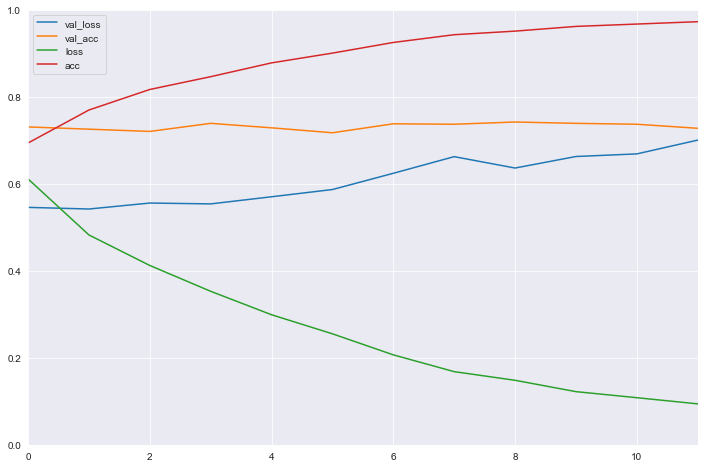

In [76]:
model_eval(history)

In [77]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[0.7917483 ]
 [0.00317485]
 [0.13817298]]


Realistic Headlines:
snowflake more  double  debut  wall street embrace tech ipos
europe economic revival imperil raising the specter grind downturn
fed debate next step after shifting approach to rate setting
[[0.371678  ]
 [0.33096963]
 [0.21523999]]


Surprisingly, I did not get great performance with this model.  The original embedded layer model worked best.  Validation loss was not kept under control.  Adding dropout layers to help with regularization helped a bit, but not enough.

## Embedding Dimensions:

With the following code, I can download the embedding vectors weights and metadata in order to upload to TensorFlow Projector.  The website is found [here](https://projector.tensorflow.org/), and if you un-comment the following code, run it, download the files, upload them to the projector, and click 'spherize data' you can see the embeddings from the neural network.

An example of this can be found in the gif in the readme file.

In [72]:
'''
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()
'''

'\ne = model.layers[0]\nweights = e.get_weights()[0]\nprint(weights.shape) # shape: (vocab_size, embedding_dim)\n\nimport io\n\nout_v = io.open(\'vecs.tsv\', \'w\', encoding=\'utf-8\')\nout_m = io.open(\'meta.tsv\', \'w\', encoding=\'utf-8\')\nfor word_num in range(1, vocab_size):\n  word = reverse_word_index[word_num]\n  embeddings = weights[word_num]\n  out_m.write(word + "\n")\n  out_v.write(\'\t\'.join([str(x) for x in embeddings]) + "\n")\nout_v.close()\nout_m.close()\n'

# Further Work:

In the future, I'd like to complete the following analysis:
- A web application that collects and analyzes headlines from various financial news sources.  It would be great to have a website where individuals or firms could keep track of products, companies, or industries they're interested in keeping track of.
- Other neural network architecture types.  I think there's more work to do on LSTM models, GRU models, or other neural network architecture types.
- New types of sentiment analysis, such as breaking news vs an opinion piece on an older issue.  There are more ways of breaking down texts aside from positive vs negative.  It would be interesting to break down some of these divisions.  
- Rate different newspapers by sentiment value.  I think it would also be fun to see which newspapers have the most positive tone!  A more accurate model, more labeled data, and more training could make this very doable.

# Conclusion:

If I were to put this into production, I would use the first embedded layer model and train it with quite a bit more data.  It would be a challenge to collect, but the model would be able to gain quite a bit more accuracy.  In the end, though, I believe it would ultimately be worth it.

This was a fun challenge.  Sentiment analysis is a fairly tried and true field of study, but it was a bit more of a challenge to try it with financial news headlines.  The words that impart sentiment tend to be much different than those in (for example) Amazon reviews or other common test cases.  

While ~81% accuracy has some definite room for improvement, it's not a bad start considering the amount of labeled data that was available for this project.  At some point, I'd love to come back to this with a larger dataset and more experience under my belt working with neural networks and take another crack at this project.

Thanks for reading, and let me know if you have any questions.

-Thomas